In [48]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None) 



In [130]:
#https://www.kaggle.com/c/house-prices-advanced-regression-techniques

original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)
original_test_data = pd.read_csv('data/test.csv',delimiter=',',header=0)

# check data quality
print original_train_data.describe()

mask = np.random.rand(len(original_train_data)) < 0.8



                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000          NaN    7553.500000     5.000000   
50%     730.500000    50.000000          NaN    9478.500000     6.000000   
75%    1095.250000    70.000000          NaN   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000

                     Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass     0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage   -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea       -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual   -0.028365    0.032628     0.251646  0.105806     1.000000   
OverallCond    0.012609   -0.059316    -0.059213 -0.005636    -0.091932   
YearBuilt     -0.012713    0.027850     0.123349  0.014228     0.572323   
YearRemodAdd  -0.021998    0.040581     0.088866  0.013788     0.550684   
MasVnrArea    -0.050298    0.022936     0.193458  0.104160     0.411876   
BsmtFinSF1    -0.005024   -0.069836     0.233633  0.214103     0.239666   
BsmtFinSF2    -0.005968   -0.065649     0.049900  0.111170    -0.059119   
BsmtUnfSF     -0.007940   -0.140759     0.132644 -0.002618     0.308159   
TotalBsmtSF   -0.015415  

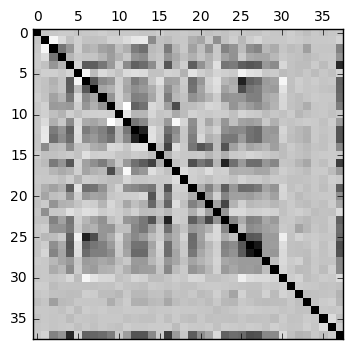

In [3]:
# plot correlation matrix
corr = original_train_data.corr()
print corr
plt.matshow(corr, cmap=plt.cm.Greys)

In [4]:
##
## JV DATA ANALYSIS
## Contents and Skew
##
part3_columns = ['TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
part3_train_data_cols = original_train_data.loc[:,part3_columns]

print "Total records = " + str(len(original_train_data))
print "<< Training data size >>"
print
print "<< Unique contents sorted >>"
for colname in part3_train_data_cols:
    contents = original_train_data[colname].unique()
    print colname, sorted(contents)
print
print "<< NA's counted >>"
for colname in part3_train_data_cols:
    na_count = original_train_data[colname].isnull().sum()
    print colname, na_count


Total records = 1460
<< Training data size >>

<< Unique contents sorted >>
TotRmsAbvGrd [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
Functional ['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev', 'Typ']
Fireplaces [0, 1, 2, 3]
FireplaceQu [nan, 'Ex', 'Fa', 'Gd', 'Po', 'TA']
GarageType [nan, '2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd']
GarageYrBlt [1915.0, 1920.0, 1930.0, 1931.0, 1935.0, 1939.0, 1945.0, 1948.0, 1953.0, 1954.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1970.0, 1973.0, 1974.0, 1976.0, 1977.0, 1981.0, 1983.0, 1985.0, 1987.0, 1989.0, 1990.0, 1991.0, 1993.0, 1995.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, nan, 1900.0, 1906.0, 1908.0, 1910.0, 1914.0, 1916.0, 1918.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1932.0, 1933.0, 1934.0, 1936.0, 1937.0, 1938.0, 1940.0, 1941.0, 1942.0, 1946.0, 1947.0, 1949.0, 1950.0, 1951.0, 1952.0, 195

#IDEAS

: Dlb-check category conversion...NaN = 0 after, but before?; address?
: Check distributions; adjust skew if necessary
: Normalization/scaling


In [5]:
print original_train_data.shape

part3_data = original_train_data[original_train_data.columns[-26:]]
print part3_data.shape


(1460, 81)
(1460, 26)


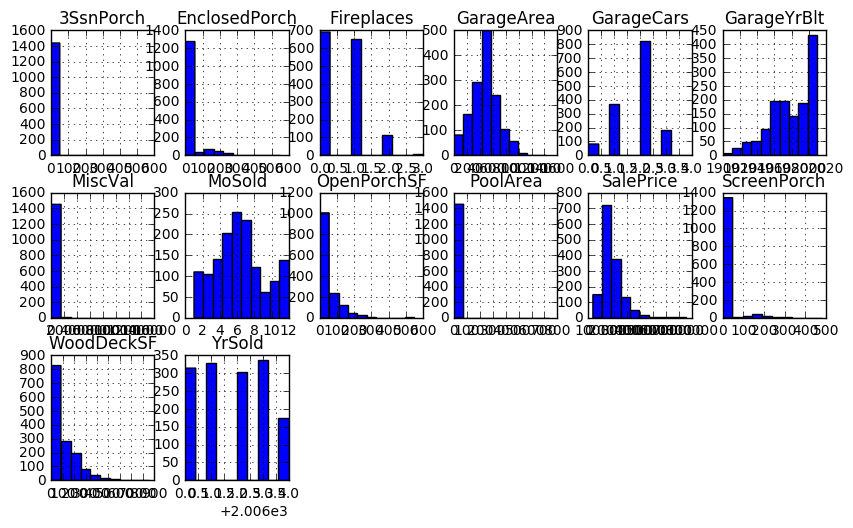

In [6]:
# histograms by feature
part3_data.hist(figsize=(10,10),layout=(5,6));

In [7]:
# plot correlation matrix
corr = part3_data.corr()
print corr


               Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  \
Fireplaces       1.000000     0.046822    0.300789    0.269141    0.200019   
GarageYrBlt      0.046822     1.000000    0.588920    0.564567    0.224577   
GarageCars       0.300789     0.588920    1.000000    0.882475    0.226342   
GarageArea       0.269141     0.564567    0.882475    1.000000    0.224666   
WoodDeckSF       0.200019     0.224577    0.226342    0.224666    1.000000   
OpenPorchSF      0.169405     0.228425    0.213569    0.241435    0.058661   
EnclosedPorch   -0.024822    -0.297003   -0.151434   -0.121777   -0.125989   
3SsnPorch        0.011257     0.023544    0.035765    0.035087   -0.032771   
ScreenPorch      0.184530    -0.075418    0.050494    0.051412   -0.074181   
PoolArea         0.095074    -0.014501    0.020934    0.061047    0.073378   
MiscVal          0.001409    -0.032417   -0.043080   -0.027400   -0.009551   
MoSold           0.046357     0.005337    0.040522    0.027974  

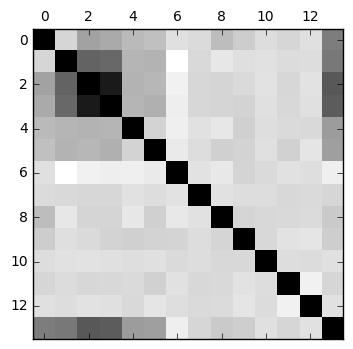

In [8]:
plt.matshow(corr, cmap=plt.cm.Greys)

In [9]:
# train data; convert categoricals to integers
obj_columns = original_train_data.select_dtypes(['object']).columns
original_train_data[obj_columns] = original_train_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_train_data = original_train_data.fillna(value=-1)

# test data; convert categoricals to integers
obj_columns = original_test_data.select_dtypes(['object']).columns
original_test_data[obj_columns] = original_test_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_test_data = original_test_data.fillna(value=-1)

train_data = original_train_data[mask]
dev_data = original_train_data[~mask]

train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )
train_data = train_data.drop( ["Id"], axis=1 )

dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
dev_data = dev_data.drop( ["Id"], axis=1 ) 

test_data = original_test_data.copy()

In [131]:
reg = LinearRegression()
reg.fit(train_data, train_labels)
#print "Coefficients: " + str(reg.coef_)
print('R^2: %1.2f' % reg.score(dev_data, dev_labels))

# various score measures
pred_labels = reg.predict(dev_data)

# r2_score should be the same as reg.score
print metrics.r2_score(dev_labels,pred_labels, multioutput='uniform_average')
print metrics.explained_variance_score(dev_labels,pred_labels, multioutput='uniform_average')

R^2: 0.71
0.71119868606
0.712430284372


In [132]:
max_score = 0
max_feature_count = 0
max_features = []

for idx in range(1,original_train_data.shape[1]):
    reg = LinearRegression()
    rfe = RFE(estimator=reg, n_features_to_select=idx, step=1)
    rfe.fit(train_data, train_labels)
    run_score = rfe.score(dev_data, dev_labels)
    if (run_score > max_score):
        max_score = run_score
        max_feature_count = idx
        max_features = rfe.support_

print "Max score: " + str(max_score)
print "# features to keep: " + str(max_feature_count)
print "Keep:"
print train_data.columns[max_features]
print "Remove:"
print train_data.columns[max_features==False]

Max score: 0.80109413645
# features to keep: 56
Keep:
Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle',
       u'OverallQual', u'OverallCond', u'YearBuilt', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'ExterQual',
       u'Foundation', u'BsmtQual', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'BsmtFullBath', u'BsmtHalfBath',
       u'FullBath', u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr',
       u'KitchenQual', u'TotRmsAbvGrd', u'Functional', u'Fireplaces',
       u'FireplaceQu', u'GarageType', u'GarageCars', u'GarageQual',
       u'PavedDrive', u'PoolArea', u'PoolQC', u'Fence', u'MiscFeature',
       u'MoSold', u'YrSold', u'SaleType', u'SaleCondition', u'HasLargeGarage'],
      dtype='object')
Remove:
Index([

In [133]:
original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)

# train data; convert categoricals to integers
obj_columns = original_train_data.select_dtypes(['object']).columns
original_train_data[obj_columns] = original_train_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_train_data = original_train_data.fillna(value=-1)

# test data; convert categoricals to integers
obj_columns = original_test_data.select_dtypes(['object']).columns
original_test_data[obj_columns] = original_test_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_test_data = original_test_data.fillna(value=-1)

print "******** DECK (PCA)"
## BASELINE
train_data = original_train_data[mask]
dev_data = original_train_data[~mask]

train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )
train_data = train_data.drop( ["Id"], axis=1 )

dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
dev_data = dev_data.drop( ["Id"], axis=1 ) 

reg = LinearRegression()
reg.fit(train_data, train_labels)
print("Baseline before deck area reduced to 1 dimension w/ PCA")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))

##
##  PORCH/DECK COLLAPSE/REMOVALS with PCA
##
#ss = StandardScaler()
#original_train_data["WoodDeckSF"] = ss.fit_transform(original_train_data["WoodDeckSF"])
#original_train_data["OpenPorchSF"] = ss.fit_transform(original_train_data["OpenPorchSF"])
#original_train_data["EnclosedPorch"] = ss.fit_transform(original_train_data["EnclosedPorch"])
#original_train_data["3SsnPorch"] = ss.fit_transform(original_train_data["3SsnPorch"])
#original_train_data["ScreenPorch"] = ss.fit_transform(original_train_data["ScreenPorch"])

porches = original_train_data.loc[:,["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]]
pca = PCA(n_components=1)
reduced_porches = pca.fit_transform(porches)
reduced_porches_df = pd.DataFrame(reduced_porches, columns=['Porches'])
print '\nPCA explained variances: ' + str(pca.explained_variance_ratio_) + "\n"

original_train_data = original_train_data.drop( ["WoodDeckSF"], axis=1 )
original_train_data = original_train_data.drop( ["OpenPorchSF"], axis=1 )
original_train_data = original_train_data.drop( ["EnclosedPorch"], axis=1 )
original_train_data = original_train_data.drop( ["3SsnPorch"], axis=1 )
original_train_data = original_train_data.drop( ["ScreenPorch"], axis=1 )
original_train_data["Porches"] = reduced_porches_df

train_data = original_train_data[mask]
dev_data = original_train_data[~mask]

train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )
train_data = train_data.drop( ["Id"], axis=1 )

dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
dev_data = dev_data.drop( ["Id"], axis=1 ) 

# CHECK IMPACT
reg = LinearRegression()
reg.fit(train_data, train_labels)
print("After before deck area features collapsed into 1 dimension with PCA")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))


******** DECK (PCA)
Baseline before deck area reduced to 1 dimension w/ PCA
R^2: 0.78302

PCA explained variances: [ 0.56933134]

After before deck area features collapsed into 1 dimension with PCA
R^2: 0.78382


In [134]:
original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)

# train data; convert categoricals to integers
obj_columns = original_train_data.select_dtypes(['object']).columns
original_train_data[obj_columns] = original_train_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_train_data = original_train_data.fillna(value=-1)

# test data; convert categoricals to integers
obj_columns = original_test_data.select_dtypes(['object']).columns
original_test_data[obj_columns] = original_test_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_test_data = original_test_data.fillna(value=-1)

print "******** DECK (SUM)"
## BASELINE
train_data = original_train_data[mask]
dev_data = original_train_data[~mask]

train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )
train_data = train_data.drop( ["Id"], axis=1 )

dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
dev_data = dev_data.drop( ["Id"], axis=1 ) 

reg = LinearRegression()
reg.fit(train_data, train_labels)
print("Baseline before deck area reduced to 1 sq footage feature (sum)")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))

##
##  PORCH/DECK COLLAPSE/REMOVALS INTO ONE SQ FT MEASUREMENT (SUM OF ALL)
##
porches = original_train_data.loc[:,["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]]
reduced_porches = porches.sum(axis=1)

original_train_data = original_train_data.drop( ["WoodDeckSF"], axis=1 )
original_train_data = original_train_data.drop( ["OpenPorchSF"], axis=1 )
original_train_data = original_train_data.drop( ["EnclosedPorch"], axis=1 )
original_train_data = original_train_data.drop( ["3SsnPorch"], axis=1 )
original_train_data = original_train_data.drop( ["ScreenPorch"], axis=1 )
original_train_data["Porches"] = reduced_porches

train_data = original_train_data[mask]
dev_data = original_train_data[~mask]

train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )
train_data = train_data.drop( ["Id"], axis=1 )
#
dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
dev_data = dev_data.drop( ["Id"], axis=1 ) 

## CHECK IMPACT
reg = LinearRegression()
reg.fit(train_data, train_labels)
print("After before deck area reduced to 1 sq footage feature (sum)")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))


******** DECK (SUM)
Baseline before deck area reduced to 1 sq footage feature (sum)
R^2: 0.78302
After before deck area reduced to 1 sq footage feature (sum)
R^2: 0.78184


In [135]:
original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)

# train data; convert categoricals to integers
obj_columns = original_train_data.select_dtypes(['object']).columns
original_train_data[obj_columns] = original_train_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_train_data = original_train_data.fillna(value=-1)

# test data; convert categoricals to integers
obj_columns = original_test_data.select_dtypes(['object']).columns
original_test_data[obj_columns] = original_test_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_test_data = original_test_data.fillna(value=-1)

train_data = original_train_data[mask]
dev_data = original_train_data[~mask]

train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )
train_data = train_data.drop( ["Id"], axis=1 )

dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
dev_data = dev_data.drop( ["Id"], axis=1 ) 

print "******** POOL"
### BASELINE
reg = LinearRegression()
reg.fit(train_data, train_labels)
#print "Coefficients: " + str(reg.coef_)
print("Baseline before pool area collapsed to binary; pool quality and area kept")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))

##
##  POOL MODIFICATIONS
##
train_data["HasLargePool"] = train_data["PoolArea"]>500
print "Number of large pools: " + str(sum(train_data["HasLargePool"]))
#train_data = train_data.drop( ["PoolQC"], axis=1 )
#train_data = train_data.drop( ["PoolArea"], axis=1 )
#
dev_data["HasLargePool"] = dev_data["PoolArea"]>0
#dev_data = dev_data.drop( ["PoolQC"], axis=1 )
#dev_data = dev_data.drop( ["PoolArea"], axis=1 )

## CHECK IMPACT
reg = LinearRegression()
reg.fit(train_data, train_labels)
print("After pool area collapsed to binary; pool quality and area kept")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))

******** POOL
Baseline before pool area collapsed to binary; pool quality and area kept
R^2: 0.78302
Number of large pools: 5
After pool area collapsed to binary; pool quality and area kept
R^2: 0.85058


In [136]:
original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)

# train data; convert categoricals to integers
obj_columns = original_train_data.select_dtypes(['object']).columns
original_train_data[obj_columns] = original_train_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_train_data = original_train_data.fillna(value=-1)

# test data; convert categoricals to integers
obj_columns = original_test_data.select_dtypes(['object']).columns
original_test_data[obj_columns] = original_test_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_test_data = original_test_data.fillna(value=-1)

train_data = original_train_data[mask]
dev_data = original_train_data[~mask]

train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )
train_data = train_data.drop( ["Id"], axis=1 )

dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
dev_data = dev_data.drop( ["Id"], axis=1 ) 

print "******** FIREPLACE"
### BASELINE
reg = LinearRegression()
reg.fit(train_data, train_labels)
print("Baseline before fireplace count >2 reduced to binary; fireplace quality kept")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))

##
##  FIREPLACE COLLAPSE/REMOVALS
##
train_data["HasManyFireplaces"] = train_data["Fireplaces"]>2
train_data = train_data.drop( ["Fireplaces"], axis=1 )
#train_data = train_data.drop( ["FireplaceQu"], axis=1 )
#
dev_data["HasManyFireplaces"] = dev_data["Fireplaces"]>2
dev_data = dev_data.drop( ["Fireplaces"], axis=1 )
#dev_data = dev_data.drop( ["FireplaceQu"], axis=1 )

## CHECK IMPACT
reg = LinearRegression()
reg.fit(train_data, train_labels)
#print "Coefficients: " + str(reg.coef_)
print("After fireplace count >2 reduced to binary; fireplace quality kept")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))



******** FIREPLACE
Baseline before fireplace count >2 reduced to binary; fireplace quality kept
R^2: 0.78302
After fireplace count >2 reduced to binary; fireplace quality kept
R^2: 0.79337


In [137]:
original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)

# train data; convert categoricals to integers
obj_columns = original_train_data.select_dtypes(['object']).columns
original_train_data[obj_columns] = original_train_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_train_data = original_train_data.fillna(value=-1)

# test data; convert categoricals to integers
obj_columns = original_test_data.select_dtypes(['object']).columns
original_test_data[obj_columns] = original_test_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
original_test_data = original_test_data.fillna(value=-1)

train_data = original_train_data[mask]
dev_data = original_train_data[~mask]

train_labels = train_data["SalePrice"].copy()
train_data = train_data.drop( ["SalePrice"], axis=1 )
train_data = train_data.drop( ["Id"], axis=1 )

dev_labels = dev_data["SalePrice"].copy()
dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
dev_data = dev_data.drop( ["Id"], axis=1 ) 

print "******** GARAGE"
### BASELINE
reg = LinearRegression()
reg.fit(train_data, train_labels)
print("Baseline before garage LargeGarage created; most others deleted")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))

##
##  FIREPLACE COLLAPSE/REMOVALS
##
train_data["HasLargeGarage"] = train_data["GarageArea"]>800
train_data = train_data.drop( ["GarageArea"], axis=1 )
train_data = train_data.drop( ["GarageFinish"], axis=1 )
#train_data = train_data.drop( ["GarageType"], axis=1 )
#train_data = train_data.drop( ["GarageYrBlt"], axis=1 )
#train_data = train_data.drop( ["GarageCars"], axis=1 )
#train_data = train_data.drop( ["GarageQual"], axis=1 )
#train_data = train_data.drop( ["GarageCond"], axis=1 )
#
dev_data["HasLargeGarage"] = dev_data["GarageArea"]>800
dev_data = dev_data.drop( ["GarageArea"], axis=1 )
dev_data = dev_data.drop( ["GarageFinish"], axis=1 )
#dev_data = dev_data.drop( ["GarageType"], axis=1 )
#dev_data = dev_data.drop( ["GarageYrBlt"], axis=1 )
#dev_data = dev_data.drop( ["GarageCars"], axis=1 )
#dev_data = dev_data.drop( ["GarageQual"], axis=1 )
#dev_data = dev_data.drop( ["GarageCond"], axis=1 )

## CHECK IMPACT
reg = LinearRegression()
reg.fit(train_data, train_labels)
#print "Coefficients: " + str(reg.coef_)
print("After garage LargeGarage created; most others deleted")
print('R^2: %1.5f' % reg.score(dev_data, dev_labels))



******** GARAGE
Baseline before garage LargeGarage created; most others deleted
R^2: 0.78302
After garage LargeGarage created; most others deleted
R^2: 0.78980
